In [2]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import Pool, cv
random_state = 7
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import warnings
import numpy as np
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA

In [3]:
tr = "trainset_ALLvsHealthy_80_target_in"
ts = "testset_ALLvsHealthy_20_target_in"


path = os.getcwd()
parent = os.path.dirname(path)

train = pd.read_csv(parent + '\Data\\' + tr + ".csv")
test = pd.read_csv(parent + '\Data\\' + ts + ".csv")

X_train = train.drop("target", axis=1)
y_train = train["target"]

X_test  = test.drop("target", axis=1)
y_test = test["target"]

In [4]:
X_train

,PAX8,CCL5,MMP14,DTX2P1-UPK3BP1-PMS2P11,BAD,PRPF8,CAPNS1,RPL35,EIF4G2,EIF3D,...,WNT6,RABEP2,FKBP15,LRCH4,MEX3D,BCAN,ACTB,GAPDH,MIR3648-2,MIR3648-1
0,9.226723,5.117150,8.491649,9.348301,5.875613,9.295862,9.675503,11.531871,10.259727,10.391409,...,9.672278,4.788977,4.084023,8.915967,5.395083,8.373858,13.304803,12.959516,4.915874,5.329516
1,8.530320,4.247610,7.610530,8.471810,5.638450,8.793810,7.611230,12.693300,4.843120,10.954800,...,6.718540,7.260950,3.529740,9.003830,3.678160,7.914630,8.949770,12.130300,6.604680,7.575050
2,8.877018,6.451803,8.020933,9.195340,6.207559,10.745656,11.188523,11.879071,11.157626,11.472299,...,9.020160,7.820956,4.068599,9.428625,4.860965,7.723813,13.412749,13.483634,4.926242,4.882589
3,8.584717,6.713449,7.853111,9.162434,7.039554,10.731903,10.202020,11.445236,11.301316,11.210408,...,8.229422,7.666866,4.319417,11.022293,5.264262,7.970409,12.377522,13.269611,5.850407,7.515944
4,7.851270,11.817200,6.556220,8.590940,5.937720,9.549050,11.183100,12.968300,4.671820,10.946200,...,6.465610,7.201440,4.260580,7.466870,3.853250,6.874200,10.634400,11.704500,6.155690,10.497400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,7.502360,7.749920,5.717440,7.406710,5.959010,9.403450,10.486900,12.609100,5.226120,11.184900,...,5.543800,8.339750,5.129650,7.040380,4.979790,6.524060,11.822200,12.215900,6.615540,7.149340
3494,9.079070,5.301004,8.097681,9.646963,6.543292,9.924539,10.750554,12.735260,11.009925,11.488529,...,9.538459,7.410794,4.225883,9.854184,5.173081,7.790125,12.075731,12.444471,5.970986,5.765216
3495,8.293874,7.158424,7.343468,8.655112,6.651382,9.479439,9.937352,12.089717,11.119689,11.416018,...,7.955676,8.640319,4.608101,10.023447,4.766663,7.581861,12.898946,12.984298,7.074160,7.768212
3496,7.554640,7.163910,6.346470,7.720690,5.786180,9.515350,9.056850,12.864900,4.330190,10.688100,...,5.646120,8.787230,4.191130,6.983580,4.065720,7.002020,9.066200,11.221000,9.389810,9.395260


In [5]:
np.arange(X_train.shape[-1])

array([    0,     1,     2, ..., 12705, 12706, 12707])

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=23)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

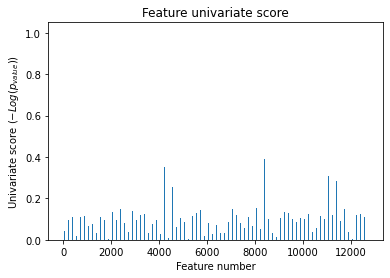

In [7]:
import matplotlib.pyplot as plt

X_indices = np.arange(X_train.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

In [8]:
scores

array([0.04111292, 0.09931482, 0.08201554, ..., 0.03535838, 0.06664881,
       0.2053652 ])

In [9]:
count = np.count_nonzero(scores > .99)

In [10]:
count

1

In [11]:
ind = np.argpartition(scores, -23)[-23:]

In [12]:
scores[ind]

array([0.45958956, 0.5695486 , 0.63438553, 0.56355295, 0.47891178,
       1.        , 0.55085833, 0.88042254, 0.53343592, 0.51245459,
       0.46168099, 0.49242662, 0.76627989, 0.52215821, 0.96487725,
       0.50534698, 0.48433789, 0.50254305, 0.54906098, 0.48342184,
       0.75072927, 0.491027  , 0.47593629])

In [13]:
X_train.columns[ind]

Index(['TRIM49B', 'SEPT10P1', 'GABPAP', 'SNORA66', 'KCNS3', 'NPY', 'SPANXC',
       'GH2', 'MAP3K19', 'HMGB1P12', 'ALX1', 'PAICSP4', 'S100A11P1', 'GH1',
       'HMGB3P1', 'HMGN2P9', 'IFNA13', 'RNU6-73P', 'RBMS2P1', 'LINC00472',
       'PCDHGA3', 'EYA4', 'CES1P1'],
      dtype='object')

In [13]:
all_reduced = pd.read_csv(parent + '\Data\\' + "testset_ALL_vs_Healthy_reduced_50_20_target_in" + ".csv")

In [14]:
columns_all_reduced = all_reduced.columns

In [15]:
np.intersect1d(columns_all_reduced, columns_anova)

array([], dtype=object)

In [22]:
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=23)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

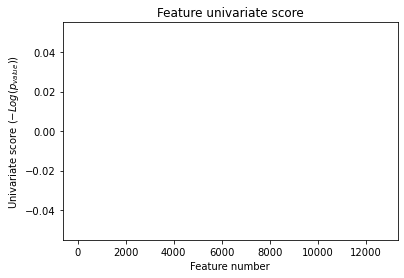

In [17]:
import matplotlib.pyplot as plt

X_indices = np.arange(X_train.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

In [26]:
ind = np.argpartition(selector.pvalues_, -23)[-23:]

In [27]:
scores[ind]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [28]:
columns_anova= X_train.columns[ind]

In [29]:
np.intersect1d(columns_all_reduced, columns_anova)

array([], dtype=object)

In [30]:
columns_anova

Index(['LRRC8E', 'RAB40A', 'HTR1D', 'OIP5', 'EPB41L1', 'ZNF750', 'TDGF1P3',
       'TRPC5', 'SPP1', 'RBBP4P1', 'CALCB', 'PLA1A', 'LMAN1L', 'CAMK2A',
       'COLEC11', 'SLC17A7', 'FOXC1', 'GRIN1', 'FAM224B', 'NACA2', 'RALYL',
       'ACTG2', 'TMEM74B'],
      dtype='object')